In [ ]:
# Loading Libraries
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import tensorflow as tf
# from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split


In [ ]:
try:
    import cupy as cp
    xp = cp
    print('# use cupy')
except:
    xp = np
    print('# use numpy')

# use cupy


In [ ]:
# Setting the random seed
xp.random.seed(123)


In [ ]:
#Defining Activation functions, Derivatives and One hot encoding
def sigmoid(x):
    return 1 / (1 + xp.exp(-x))


def sigmoidDerivative(x):
    return xp.multiply(x, (1 - x))


def relu(x):
    return xp.maximum(0.0, x)


def reluDerivative(x):
    return 1 * (x > 0)


def softmax(x):
    # To avoid Overflow
    tmp_max = x - x.max(axis=1)[:, xp.newaxis]
    xp.exp(tmp_max, out=x)
    x /= x.sum(axis=1)[:, xp.newaxis]
    return x
    # exps = xp.exp(x - xp.max(x))
    # return exps / xp.sum(exps)

def tanh(x):
    return xp.tanh(x)

def tanhDerivative(x):
    return 1-xp.square(xp.tanh(x))

def one_hot(y, C, gpu_flag=True):

    if gpu_flag:
      y=cp.array(y)
      
    res = xp.eye(C)[xp.array(y).reshape(-1)]
    return res.reshape(list(y.shape)+[C])



# This section implements the Multi layer perceptron from scratch using the numpy library.

In [ ]:
#MLP implementation from scratch
class MLP:

    def __init__(self, layer_list, act_fn_hidden='relu', outputactivation=softmax):
        self.n_layers = len(layer_list)
        self.layer_list = layer_list

        if act_fn_hidden =='relu':
            self.hiddenactivation=relu
            self.hiddenactivation_derivative=reluDerivative
        elif act_fn_hidden == 'sigmoid':
            self.hiddenactivation=sigmoid
            self.hiddenactivation_derivative=sigmoidDerivative
        else:
            self.hiddenactivation=tanh
            self.hiddenactivation_derivative=tanhDerivative

        self.outputactivation=outputactivation

        # Initialize parameters
        self.params0,self.biases0 = self.initialize_params(self.layer_list)
        self.momentum_params_init, self.adam_params1_init, self.adam_params2_init = self.optimizer_params(self.layer_list)
        self.momentum_bias_init, self.adam_bias1_init, self.adam_bias2_init = self.optimizer_bias(self.layer_list)

    def optimizer_params(self, ll):
        m_list ,a1_list, a2_list = [], [], []

        for i in range(self.n_layers - 2):
            if i == 0:
                m_i= xp.zeros([ll[0], ll[1]])
                a1_i = xp.zeros([ll[0], ll[1]])
                a2_i = xp.zeros([ll[0], ll[1]])
                m_list.append(m_i)
                a1_list.append(a1_i)
                a2_list.append(a2_i)
            else:
                m_hl = xp.zeros([ll[i], ll[i + 1]])
                a1_hl = xp.zeros([ll[i], ll[i + 1]])
                a2_hl = xp.zeros([ll[i], ll[i + 1]])
                m_list.append(m_hl)
                a1_list.append(a1_hl)
                a2_list.append(a2_hl)

        m_o = xp.zeros([ll[-2], ll[-1]])
        a1_o = xp.zeros([ll[-2], ll[-1]])
        a2_o = xp.zeros([ll[-2], ll[-1]])
        m_list.append(m_o)
        a1_list.append(a1_o)
        a2_list.append(a2_o)

        return m_list,a1_list,a2_list

    def optimizer_bias(self, ll):
        m_b ,a1_b, a2_b = [], [], []

        for i in range(self.n_layers - 2):
            if i == 0:
                m_i= xp.zeros([ll[1]])
                a1_i = xp.zeros([ll[1]])
                a2_i = xp.zeros([ll[1]])
                m_b.append(m_i)
                a1_b.append(a1_i)
                a2_b.append(a2_i)
            else:
                m_hl = xp.zeros([ll[i + 1]])
                a1_hl = xp.zeros([ll[i + 1]])
                a2_hl = xp.zeros([ll[i + 1]])
                m_b.append(m_hl)
                a1_b.append(a1_hl)
                a2_b.append(a2_hl)

        m_o = xp.zeros([ll[-1]])
        a1_o = xp.zeros([ll[-1]])
        a2_o = xp.zeros([ll[-1]])
        m_b.append(m_o)
        a1_b.append(a1_o)
        a2_b.append(a2_o)

        # for i in range(len(m_b)):
        #   print("init bias",m_b[i].shape)
        
        return m_b,a1_b,a2_b


    def initialize_params(self, ll, method="Glorot-Normal"):

        params_init = []

        if method == "Class":
            for i in range(self.n_layers - 2):
                # print(i)
                if i == 0:
                    w_i = xp.random.randn(ll[0], ll[1]) * 0.01
                    params_init.append(w_i)
                else:
                    w_hl = xp.random.randn(ll[i], ll[i + 1]) * 0.01
                    params_init.append(w_hl)
            w_o = xp.random.randn(ll[-2], ll[-1]) * 0.01
            params_init.append(w_o)

        elif method == "Glorot-Uniform" :
            for i in range(self.n_layers - 2):
                # print(i)
                if i == 0:
                    w_i = xp.random.randn(ll[0], ll[1]) * xp.sqrt(2. / ll[0])
                    params_init.append(w_i)
                else:
                    w_hl = xp.random.randn(ll[i], ll[i + 1]) * xp.sqrt(2. / ll[i])
                    params_init.append(w_hl)
            w_o = xp.random.randn(ll[-2], ll[-1]) * xp.sqrt(2. / ll[-2])
            params_init.append(w_o)

        elif method == "Glorot-Normal" :

            for i in range(self.n_layers - 2):
                # print(i)
                if i == 0:
                    s=xp.sqrt(6. /ll[0])
                    w_i = xp.random.normal(0,s,(ll[0], ll[1]))
                    params_init.append(w_i)
                else:
                    s=xp.sqrt(6. /(ll[i]+ll[0]))
                    w_hl = xp.random.normal(0,s,(ll[i], ll[i+1]))
                    params_init.append(w_hl)
            s=xp.sqrt(6. /(ll[-2]+ll[-1]))     
            w_o = xp.random.normal(0,s,(ll[-2], ll[-1]))
            params_init.append(w_o)

        else:
            print(" Incorrect initialization method. Please choose from the Class code, Glorot-uniform or Glorot-normal")


        bias_init=[]
        for i in range(self.n_layers - 2):
            if i == 0:
                b_i= xp.zeros([ll[1]])
                bias_init.append(b_i)
            else:
                b_hl = xp.zeros([ll[i + 1]])
                bias_init.append(b_hl)

        b_o = xp.zeros([ll[-1]])
        bias_init.append(b_o)

        return params_init, bias_init


    def fit(self, x, y, optimizer):
        N, D = x.shape


        def gradient(x, y, params, biases):
            # print("Enter Gradient")
            #y_onehot = one_hot(y, C=10)
            # Forward Propagation
            z_list=[]
            for i,w in enumerate(params[:-1]):
                if i==0:
                    z = self.hiddenactivation(xp.dot(x,w)+biases[i])  # N x M
                    z_list.append(z)

                else:
                    z = self.hiddenactivation(xp.dot(z_list[i-1], w)+biases[i])
                    z_list.append(z)


            if len(params)==1: # In case of No Hidden Layer
                yh = self.outputactivation(xp.dot(x,params[-1]) + biases[-1] ) # N X C
            else:
                yh = self.outputactivation(xp.dot(z_list[-1],params[-1]) + biases[-1]) # N x C

            # print("Enter Backprop")
            #Backward Propogation
            dy = xp.subtract(yh,y) # NxC

            dparams, dz_list, dbiases=[], [], []
            for j,w in list(enumerate(reversed(params)))[:-1]:
                if j==0:
                    dw=xp.dot(z_list[-1].T, dy)/N
                    db=np.mean(dy,axis=0)
                    dbiases.append(db)
                    dparams.append(dw)
                    # print(dy.shape, w.shape)
                    dz= xp.dot(dy,w.T)
                    # print(dz.shape)
                    dz_list.append(dz)
                else:
                    dw = xp.dot(z_list[-1-j].T, dz_list[j-1]* self.hiddenactivation_derivative(z_list[-j]))/N
                    db = np.mean(dz_list[j-1]*self.hiddenactivation_derivative(z_list[-j]), axis=0)
                    dbiases.append(db)    
                    dparams.append(dw)
                    dz = xp.dot(dz_list[j-1], w.T)
                    dz_list.append(dz)

            # Input Layer
            if len(params)==1:
                dw_i=xp.dot(x.T, dy)/N
                db_i=np.mean(dy,axis=0)
            else:
                dw_i= xp.dot(x.T, dz_list[-1]*self.hiddenactivation_derivative(z_list[0]))/N
                db_i=np.mean(dz_list[-1]*self.hiddenactivation_derivative(z_list[0]), axis=0)
            dbiases.append(db_i)
            dparams.append(dw_i)

            # for i in range(len(dbiases)):
            #   print("dbias",dbiases[i].shape)

            return list(reversed(dparams)), list(reversed(dbiases)), yh


        # print("Enter fit")    
        # params0 = self.initialize_params(self.layer_list)
        self.params,self.biases = optimizer.run(gradient, x, y, self.params0,self.biases0,
                                                self.momentum_params_init, self.momentum_bias_init, 
                                                self.adam_params1_init, self.adam_params2_init, self.adam_bias1_init, self.adam_bias2_init,
                                                self.adam_params1_init, self.adam_params2_init, self.adam_bias1_init, self.adam_bias2_init,)

        return self

    def predict(self, x):

        # print("Enter predict")
        zh = []
        for i, w in enumerate(self.params[:-1]):
            if i == 0:
                z = self.hiddenactivation(xp.dot(x, w)+self.biases[i])  # N x M
                zh.append(z)

            else:
                z = self.hiddenactivation(xp.dot(zh[i - 1], w) + self.biases[i])
                zh.append(z)

        if len(self.params)==1: # No hidden Layer
            yh = self.outputactivation(xp.dot(x, self.params[-1]) +self.biases[-1]) # N x C
        else:
            yh = self.outputactivation(xp.dot(zh[-1], self.params[-1]) + self.biases[-1])  # N x C
        return yh


In [ ]:
class GradientDescent:

    def __init__(self, learning_rate=.01, max_iters=1e4, epsilon=1e-8, plot=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.plot_flag=plot

    def run(self, gradient_fn, x, y, params, mom_param=None, adam_param1=None, adam_param2=None, adam_param1_adj=None, adam_param2_adj=None):
        ll_list, iter_list=[],[]
        norms = xp.array([xp.inf])
        t = 1
        while xp.any(norms > self.epsilon) and t < self.max_iters:
            grad,yh = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = xp.array([xp.linalg.norm(g) for g in grad])
            ll = log_loss(y, yh)
            ll_list.append(ll)
            iter_list.append(t)
        if self.plot_flag:
            single_plot(iter_list, ll_list, "MNIST", "Iteration", "Log loss", "GD Log Loss Curves", ["Train Loss"])
        return params


In [ ]:
class SGD:
    def __init__(self, learning_rate=.01, epsilon=1e-8, max_iters=1e4, batch_size=128, method= 'vanilla', l2 = 0,  plot=False):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.batch_size=batch_size
        self.plot_flag=plot
        self.method=method
        self.beta1=0.90
        self.beta2=0.99
        self.lambd=l2/self.batch_size

    def run(self, gradient_fn, x, y, params,biases, mom_param=None,mom_bias=None, 
            adam_param1=None,adam_param2=None, adam_bias1=None, adam_bias2=None,
            adam_param1_adj=None, adam_param2_adj=None, adam_bias1_adj=None, adam_bias2_adj=None):
        # print("Entering SGD run")
        ll_list, iter_list=[],[]
        norms = xp.array([xp.inf])
        t=1
        while xp.any(norms > self.epsilon) and t < self.max_iters:
            # Shuffling the dataset
            msk = xp.random.permutation(x.shape[0])[:self.batch_size]
            x_tr = x[msk,:]
            y_tr= y[msk]
            grad, grad_b, yh = gradient_fn(x_tr, y_tr, params,biases)
            for p in range(len(params)):
                # print("param update loop")
                if self.method == 'vanilla':
                    params[p] -= self.learning_rate * (grad[p] + self.lambd * params[p])
                    biases[p] -= self.learning_rate * (grad_b[p])
                elif self.method == 'momentum':
                    mom_param[p] = self.beta1 * mom_param[p] + self.learning_rate * (grad[p] + self.lambd * params[p])
                    mom_bias[p] = self.beta1 * mom_bias[p] + self.learning_rate * (grad_b[p])
                    #print("mom_params",params[p].shape, mom_param[p].shape)
                    #print("mom_bias",biases[p].shape, mom_bias[p].shape)
                    params[p] -= mom_param[p]
                    biases[p] -= mom_bias[p]

                elif self.method == 'adam':
                    adam_param1[p] = self.beta1 * adam_param1[p] + (1 - self.beta1) * (grad[p] + self.lambd * params[p])
                    adam_param2[p] = self.beta2 * adam_param2[p] + (1 - self.beta2) * xp.square(grad[p] + self.lambd * params[p])
                    adam_bias1[p] = self.beta1 * adam_bias1[p] + (1 - self.beta1) * (grad_b[p])
                    adam_bias2[p] = self.beta2 * adam_bias2[p] + (1 - self.beta2) * xp.square(grad_b[p])
                    adam_param1_adj[p]= adam_param1[p]/ (1 - xp.power(self.beta1, self.batch_size))
                    adam_param2_adj[p] = adam_param2[p] / (1 - xp.power(self.beta1, self.batch_size))
                    adam_bias1_adj[p]= adam_bias1[p]/ (1 - xp.power(self.beta1, self.batch_size))
                    adam_bias2_adj[p] = adam_bias2[p] / (1 - xp.power(self.beta1, self.batch_size))
                    params[p]-= self.learning_rate * (adam_param1_adj[p] / (xp.sqrt(adam_param2_adj[p]) + self.epsilon))
                    biases[p]-= self.learning_rate * (adam_bias1_adj[p] / (xp.sqrt(adam_bias2_adj[p]) + self.epsilon))
            t +=1
            norms = xp.array([xp.linalg.norm(g) for g in grad])
            # print("before log loss")
            ll = log_loss(y_tr, yh)
            #print("after log loss")
            ll_list.append(ll)
            iter_list.append(t)
            # print("Exit SGD")
        if self.plot_flag:
            single_plot(iter_list, ll_list, "MNIST", "Iteration", "Log loss", "SGD Log Loss Curves", ["Train Loss"])
        return params, biases

In [ ]:
#Processing and plotting functions
def preprocess(x ,gpu_flag=False):

    if gpu_flag:
      x=cp.array(x)

    # Scaling the data
    res = x/255

    # Flatten the data
    res = res.reshape(res.shape[0], res.shape[1] * res.shape[2])

    # Zero Centering the data
    mu=xp.mean(res, axis=1).reshape(res.shape[0], 1)
    # print(type(mu), type(res))
    res = xp.subtract(res,mu)

    return res



def eval_acc(y, y_pred_onehot):
    y_pred=xp.argmax(y_pred_onehot, axis=1)
    y_true = xp.argmax(y, axis=1)
    accuracy = xp.sum(y_pred == y_true) / y_true.shape[0]
    return accuracy

def log_loss(targets, predictions):
    eps=1e-16
    N = predictions.shape[0]
    ce = -xp.sum(targets * xp.log(predictions+eps)) / N
    return ce

def plot_decision_boundary(x , model ,xlabel, ylabel):
    x0v = xp.linspace(xp.min(x[:,0]), xp.max(x[:,0]), 200)
    x1v = xp.linspace(xp.min(x[:,1]), xp.max(x[:,1]), 200)
    x0,x1 = xp.meshgrid(x0v, x1v)
    x_all = xp.vstack((x0.ravel(),x1.ravel())).T
    yh_all = model.predict(x_all) > .5
    plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title('Decision Boundary of the MLP')
    plt.show()

def single_plot(x_list, y_list, filename, x_label, y_label, plot_name, legend):
    fig = plt.figure()
    sb = fig.add_subplot(1, 1, 1)
    plt.plot(x_list, y_list, linewidth=2, color='r', label=legend[0])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.xticks(x_list)
    # sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    header = plot_name + " Metrics: " + filename
    plt.title(header)
    plt.legend(loc="upper right")
    plt.show()
    plt.close(fig)


def double_plot(x_list, y_list, y1_list, filename, x_label, y_label, plot_name, legend):
    fig = plt.figure()
    sb = fig.add_subplot(1, 1, 1)
    plt.plot(x_list, y_list, linewidth=2, color='r',label=legend[0])
    plt.plot(x_list, y1_list, linewidth=2,color='b', label=legend[1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.xticks(x_list)
    # sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    header = plot_name + " Metrics: " + filename
    plt.title(header)
    plt.legend(loc="upper right")
    plt.show()
    plt.close(fig)


In [ ]:
def run_epoch(x, y, x_test, y_test, model, epoch, l = 0.1, method = 'momentum', l2 = 0):
     
     acc_train_list, acc_test_list, ll_train_list, ll_test_list, epoch_list=[], [], [], [], []

     for i in range(1,epoch):
        # We can add layers as needed
        # Fitting the Model
        bs=128 # Setting batch size
        mi=int(x.shape[0]/bs)+1 # Setting maximum steps per epoch
        # print("before optimiser")
        optimizer = SGD(learning_rate=l, max_iters=mi, batch_size=bs, method = method, l2=l2 , plot=False)
        model_trained = model.fit(x, y, optimizer)
        # print("after optimiser")
        # Predicting training and test samples
        yh_train = model_trained.predict(x)
        yh_test = model_trained.predict(x_test)
        # print("after model")


        # Calculating accuracy and log loss metrics
        acc_train = eval_acc(y, yh_train)
        acc_test = eval_acc(y_test, yh_test)
        # print("After accuracy")

        ll_train=log_loss(y, yh_train)
        ll_test= log_loss(y_test,yh_test)

        # print("after log loss")

        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        ll_train_list.append(ll_train)
        ll_test_list.append(ll_test)
        epoch_list.append(i)
        
     return epoch_list, acc_train_list, acc_test_list,  ll_train_list,  ll_test_list  


In [ ]:
def hyperparameter_tuning(x, y, l_list, a_fn, lr_list, epoch_list2, test_percent=0.30):
    start_time = time.time()
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_percent, random_state=42)
    
    if xp==cp:
      x_train=cp.array(x_train)
      x_val=cp.array(x_val)
      y_train=cp.array(y_train)
      y_val=cp.array(y_val)

    l_grid, ll_grid, epoch_grid = [], [], []

    for l in lr_list:
        ll_row = []
        e_row = []
        l_row = []
        for e in epoch_list2:
            model = MLP(l_list, a_fn)
            epoch_list, acc_train_list, acc_test_list,  ll_train_list,  ll_test_list = run_epoch(x_train, y_train, x_val, y_val, model, e, l, 'momentum')
            ll_row.append(float(ll_test_list[-1]))
            l_row.append(l)
            e_row.append(e)
            double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "loss", "loss Curves LR:"+str(l), ["Train", "Validation"])

        l_grid.append(l_row)
        ll_grid.append(ll_row)
        epoch_grid.append(e_row)
    

    ll_grid = xp.array(ll_grid)
    l_grid = xp.array(l_grid) 
    epoch_grid = xp.asarray(epoch_grid)
    min_ll = xp.min(ll_grid)

   # cupy.asarray(cupy.nonzero(a), dtype=int)
    a=ll_grid == xp.min(ll_grid)
    b= xp.nonzero(a)
    pos_min_ll = xp.array(b, dtype=int)
    epoch_opt = epoch_grid[pos_min_ll[0], pos_min_ll[1]]
    l_opt = l_grid[pos_min_ll[0], pos_min_ll[1]]

  
    print(f" Optimum number of Epochs: {epoch_opt} Optimum Learning Rate:{l_opt} Lowest loss value: {min_ll}")

    Total_time = str(round(time.time() - start_time, 2))  
    print(f"Total time Taken: {Total_time}")

    return int(epoch_opt), float(l_opt), min_ll

In [ ]:
#Loading and processing data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = preprocess(train_images, gpu_flag=True)
test_images= preprocess(test_images, gpu_flag=True)
train_labels = one_hot(train_labels, C = 10, gpu_flag=True)
test_labels = one_hot(test_labels, C = 10, gpu_flag=True)

11493376/11490434 [==============================] - 0s 0us/step


run till this part for initializing the code

  # # TASK 1(PART A)

# Hyper-parameter tuning (Learning rate)

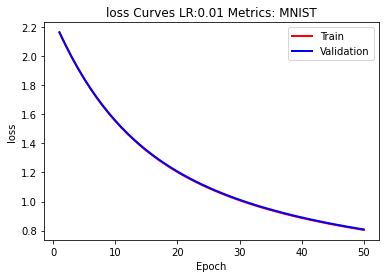

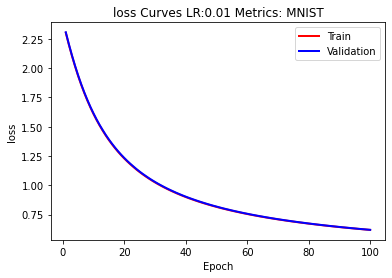

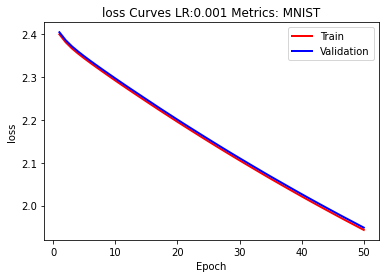

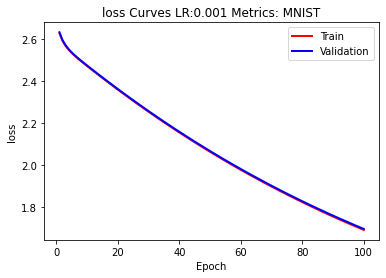

 Optimum number of Epochs: [101] Optimum Learning Rate:[0.01] Lowest loss value: 0.6190393638160314
Total time Taken: 110.18


In [ ]:
 # Running Hyper-parameter tuning
lr_list=[0.01,0.001]
epoch_list=[51,101]
#model = MLP([784, 10], 'relu')
l_list = [784, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




Epoch : 10 ========= Accuracy_Train : 0.49183333333333334, Accuracy_Test : 0.4944
Epoch : 10 ========= Loss_Train : 1.6619470600009416, Loss_Test : 1.6488058365893554
Epoch : 20 ========= Accuracy_Train : 0.6510333333333334, Accuracy_Test : 0.6571
Epoch : 20 ========= Loss_Train : 1.2731201207936464, Loss_Test : 1.2532594936664057
Epoch : 30 ========= Accuracy_Train : 0.7301166666666666, Accuracy_Test : 0.7353
Epoch : 30 ========= Loss_Train : 1.058987523795268, Loss_Test : 1.0360014861432756
Epoch : 40 ========= Accuracy_Train : 0.7705333333333333, Accuracy_Test : 0.7762
Epoch : 40 ========= Loss_Train : 0.9265295202104611, Loss_Test : 0.9022268228372201
Epoch : 50 ========= Accuracy_Train : 0.7971666666666667, Accuracy_Test : 0.8042
Epoch : 50 ========= Loss_Train : 0.8364468260811809, Loss_Test : 0.8111409270639891
Epoch : 60 ========= Accuracy_Train : 0.8122666666666667, Accuracy_Test : 0.8203
Epoch : 60 ========= Loss_Train : 0.7713860162220301, Loss_Test : 0.7457348428314325
Epoc

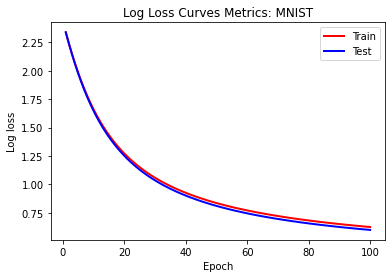

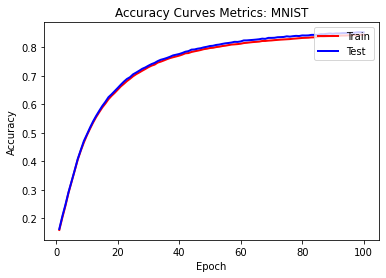

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = 'momentum', plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")
#Log Loss Curves
double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# # TASK 1(PART B)

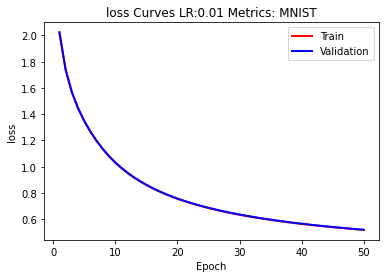

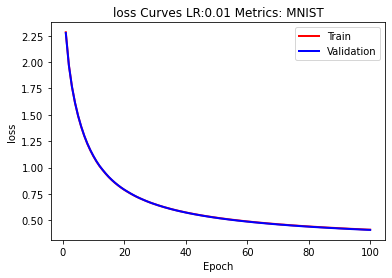

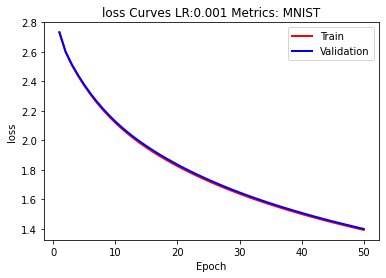

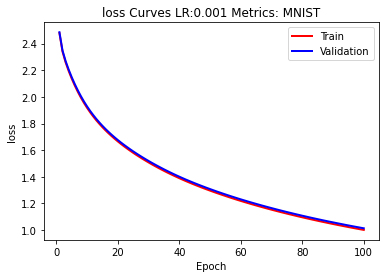

 Optimum number of Epochs: [101] Optimum Learning Rate:[0.01] Lowest loss value: 0.40936758728241457
Total time Taken: 179.52


In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.01,0.001]
epoch_list=[51,101]
l_list = [784, 128, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




Epoch : 10 ========= Accuracy_Train : 0.7065833333333333, Accuracy_Test : 0.7294
Epoch : 10 ========= Loss_Train : 1.055147503233511, Loss_Test : 1.011637005659259
Epoch : 20 ========= Accuracy_Train : 0.7892166666666667, Accuracy_Test : 0.8065
Epoch : 20 ========= Loss_Train : 0.7734098921454647, Loss_Test : 0.7347203926363036
Epoch : 30 ========= Accuracy_Train : 0.8206166666666667, Accuracy_Test : 0.8353
Epoch : 30 ========= Loss_Train : 0.6500296102055642, Loss_Test : 0.6150594501361802
Epoch : 40 ========= Accuracy_Train : 0.8387166666666667, Accuracy_Test : 0.8524
Epoch : 40 ========= Loss_Train : 0.5789308426557201, Loss_Test : 0.5477245808752392
Epoch : 50 ========= Accuracy_Train : 0.8511833333333333, Accuracy_Test : 0.8635
Epoch : 50 ========= Loss_Train : 0.5323969392211759, Loss_Test : 0.5037829981566132
Epoch : 60 ========= Accuracy_Train : 0.8589666666666667, Accuracy_Test : 0.8685
Epoch : 60 ========= Loss_Train : 0.4991579632494774, Loss_Test : 0.47263638787872925
Epoch

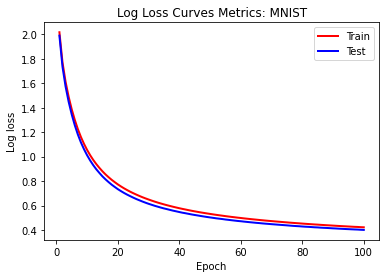

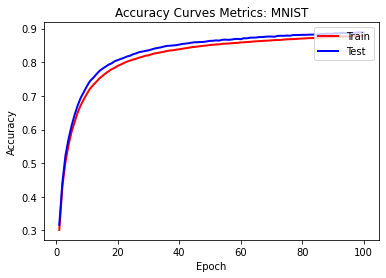

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs,  method = 'momentum', plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# # TASK 1(PART C)

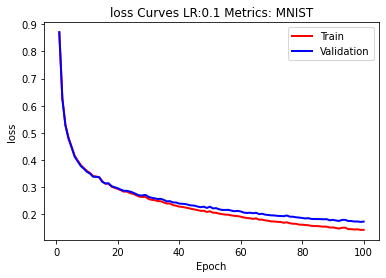

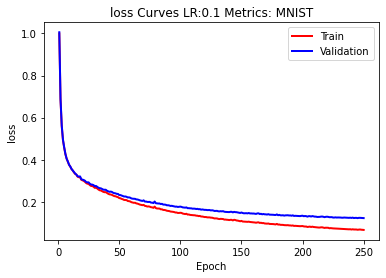

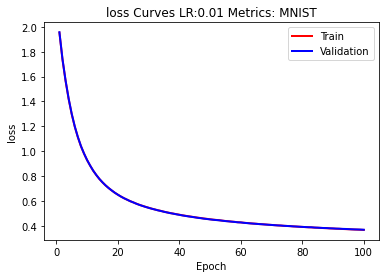

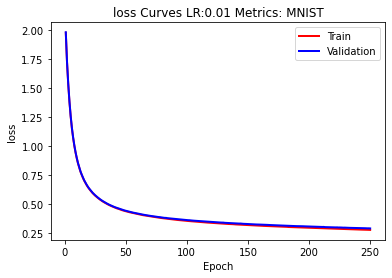

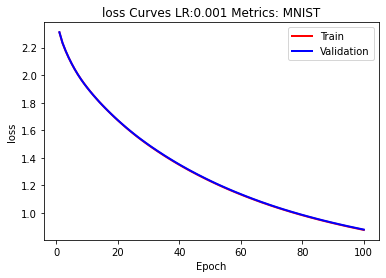

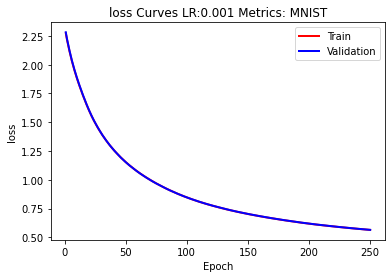

 Optimum number of Epochs: [251] Optimum Learning Rate:[0.1] Lowest loss value: 0.12288017661169089
Total time Taken: 842.55


In [ ]:
 # Running Stochastic Gradient Descent

lr_list=[0.1,0.01,0.001]
epoch_list=[101,251]
l_list = [784, 128, 128, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)





Epoch : 10 ========= Accuracy_Train : 0.8964, Accuracy_Test : 0.9012
Epoch : 10 ========= Loss_Train : 0.3568800713621479, Loss_Test : 0.3440338404056822
Epoch : 20 ========= Accuracy_Train : 0.9129666666666667, Accuracy_Test : 0.9138
Epoch : 20 ========= Loss_Train : 0.29700825253422125, Loss_Test : 0.2909728654935148
Epoch : 30 ========= Accuracy_Train : 0.9237333333333333, Accuracy_Test : 0.9238
Epoch : 30 ========= Loss_Train : 0.26088968916922606, Loss_Test : 0.2576967741413635
Epoch : 40 ========= Accuracy_Train : 0.9297, Accuracy_Test : 0.928
Epoch : 40 ========= Loss_Train : 0.23714579365219793, Loss_Test : 0.23486567703412106
Epoch : 50 ========= Accuracy_Train : 0.9355666666666667, Accuracy_Test : 0.9335
Epoch : 50 ========= Loss_Train : 0.2180546937531948, Loss_Test : 0.21929781913941834
Epoch : 60 ========= Accuracy_Train : 0.9411666666666667, Accuracy_Test : 0.94
Epoch : 60 ========= Loss_Train : 0.2001781901171906, Loss_Test : 0.2026992082740176
Epoch : 70 ========= Accur

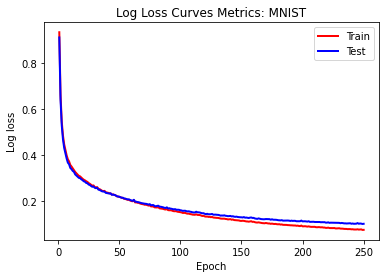

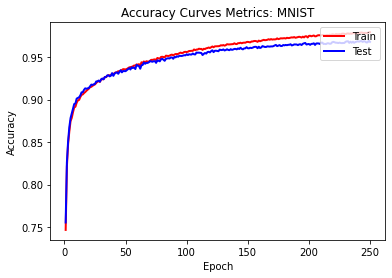

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = 'momentum', plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# # TASK 2(SIGMOID)

In [ ]:
 # Running Stochastic Gradient Descent

lr_list=[0.1,0.01,0.05]
epoch_list=[101,251,501]
l_list = [784, 128, 128, 10]
a_fn = 'sigmoid'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)






Epoch : 10 ========= Accuracy_Train : 0.19501666666666667, Accuracy_Test : 0.1909
Epoch : 10 ========= Loss_Train : 2.277326714612627, Loss_Test : 2.27797002260544
Epoch : 20 ========= Accuracy_Train : 0.28226666666666667, Accuracy_Test : 0.2832
Epoch : 20 ========= Loss_Train : 2.2368767474189535, Loss_Test : 2.236330995940819
Epoch : 30 ========= Accuracy_Train : 0.3901, Accuracy_Test : 0.3952
Epoch : 30 ========= Loss_Train : 2.1981121288013306, Loss_Test : 2.1966455060399848
Epoch : 40 ========= Accuracy_Train : 0.439, Accuracy_Test : 0.4524
Epoch : 40 ========= Loss_Train : 2.160274395538269, Loss_Test : 2.1575762965950167
Epoch : 50 ========= Accuracy_Train : 0.508, Accuracy_Test : 0.525
Epoch : 50 ========= Loss_Train : 2.1217022152472356, Loss_Test : 2.118140374202975
Epoch : 60 ========= Accuracy_Train : 0.5386166666666666, Accuracy_Test : 0.5498
Epoch : 60 ========= Loss_Train : 2.0823706817695355, Loss_Test : 2.0777624028100714
Epoch : 70 ========= Accuracy_Train : 0.5812333

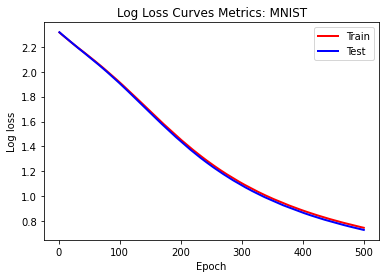

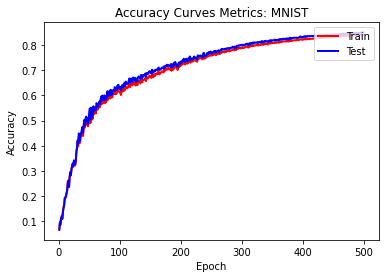

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'sigmoid')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# #TASK 2(TANH)

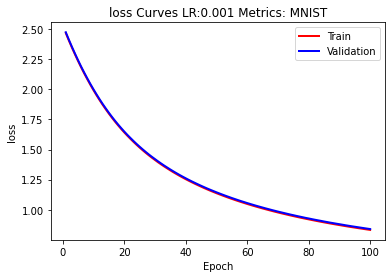

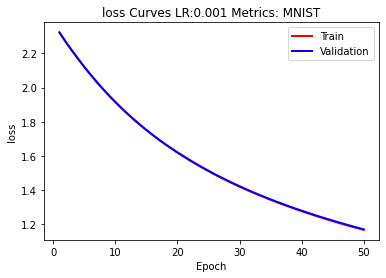

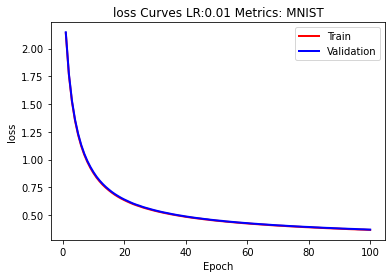

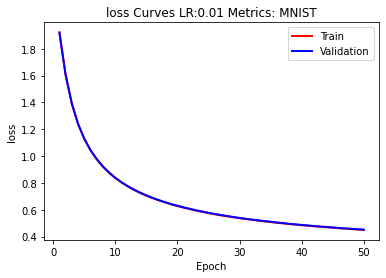

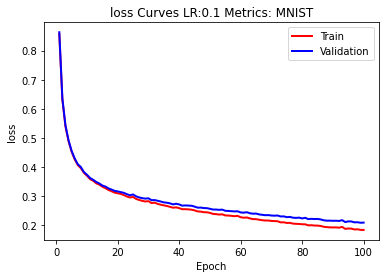

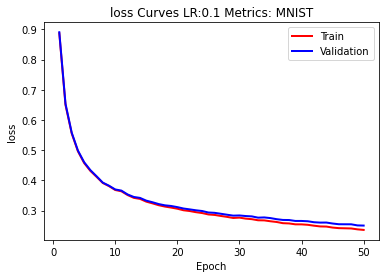

 Optimum number of Epochs: [101] Optimum Learning Rate:[0.1] Lowest loss value: 0.20755504290406918
Total time Taken: 367.61


In [ ]:
 # Running Stochastic Gradient Descent
import time
lr_list=[0.001,0.01, 0.1]
epoch_list=[101,51]
l_list = [784, 128, 128, 10]
a_fn = 'tanh'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)



Epoch : 10 ========= Accuracy_Train : 0.77105, Accuracy_Test : 0.7849
Epoch : 10 ========= Loss_Train : 0.869151277166705, Loss_Test : 0.8430213295595534
Epoch : 20 ========= Accuracy_Train : 0.8286166666666667, Accuracy_Test : 0.837
Epoch : 20 ========= Loss_Train : 0.6421916785346717, Loss_Test : 0.6195544718357856
Epoch : 30 ========= Accuracy_Train : 0.8505, Accuracy_Test : 0.8592
Epoch : 30 ========= Loss_Train : 0.5453528128823957, Loss_Test : 0.5244353761880206
Epoch : 40 ========= Accuracy_Train : 0.865, Accuracy_Test : 0.8715
Epoch : 40 ========= Loss_Train : 0.4889634440121125, Loss_Test : 0.4695658987314555
Epoch : 50 ========= Accuracy_Train : 0.8741333333333333, Accuracy_Test : 0.8808
Epoch : 50 ========= Loss_Train : 0.45174789112619923, Loss_Test : 0.4338636602318991
Epoch : 60 ========= Accuracy_Train : 0.8805333333333333, Accuracy_Test : 0.8881
Epoch : 60 ========= Loss_Train : 0.42561498545146736, Loss_Test : 0.40801746190338833
Epoch : 70 ========= Accuracy_Train : 0

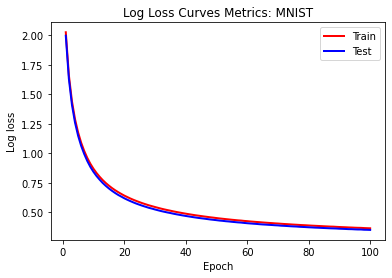

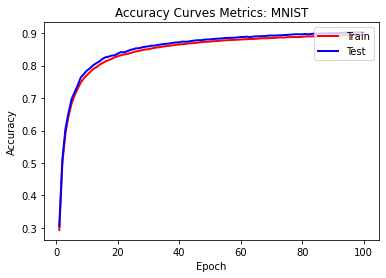

In [ ]:
# Running Stochastic Gradient Descent
epoch_opt=101
lr_opt=0.1
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'tanh')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# #TASK 3 (REGULARIZATION)

Lambda: 0.1 Accuracy0.7835555555555556
Lambda: 0.01 Accuracy0.8171111111111111
Lambda: 0.001 Accuracy0.8128333333333333


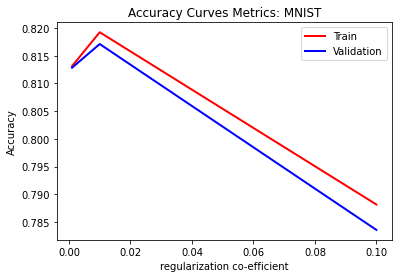

In [ ]:
# Running Stochastic Gradient Descent
l2_list = [0.1,0.01, 0.001]

acc_train_list2, acc_test_list2 =[], []

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)

epoch_list2=[]
e = 200

for l2 in l2_list:
    model = MLP([784, 128, 128, 10], 'relu')
    epoch_list, acc_train_list, acc_test_list,  ll_train_list,  ll_test_list = run_epoch(x=x_train, y=y_train, x_test=x_val, y_test=y_val, 
                                                                                         model=model, epoch=e, l2=l2, method='momentum', l=0.001 )
         
    acc_train_list2.append(acc_train_list[-1])
    acc_test_list2.append(acc_test_list[-1])
    epoch_list2.append(l2)
    print(f"Lambda: {l2} Accuracy{acc_test_list[-1]}")
  
double_plot(epoch_list2, acc_train_list2, acc_test_list2, "MNIST", "regularization co-efficient", "Accuracy", "Accuracy Curves", ["Train", "Validation"])
    
#Accuracy curves
#double_plot(epoch_list2, acc_train_list2, acc_test_list2, "MNIST", "regularization co-efficient", "Accuracy", "Accuracy Curves", ["Train", "Test"])
    

Epoch : 10 ========= Accuracy_Train : 0.7835666666666666, Accuracy_Test : 0.7917
Epoch : 10 ========= Loss_Train : 0.8479864950183218, Loss_Test : 0.8247814225471082
Epoch : 20 ========= Accuracy_Train : 0.8335166666666667, Accuracy_Test : 0.8414
Epoch : 20 ========= Loss_Train : 0.6393942350383143, Loss_Test : 0.6147443393392801
Epoch : 30 ========= Accuracy_Train : 0.8533166666666666, Accuracy_Test : 0.8627
Epoch : 30 ========= Loss_Train : 0.5578657746616812, Loss_Test : 0.5340739421039956
Epoch : 40 ========= Accuracy_Train : 0.8643, Accuracy_Test : 0.8733
Epoch : 40 ========= Loss_Train : 0.515336160042015, Loss_Test : 0.492027576425767
Epoch : 50 ========= Accuracy_Train : 0.8715166666666667, Accuracy_Test : 0.8795
Epoch : 50 ========= Loss_Train : 0.4885738653810629, Loss_Test : 0.46678541442650295
Epoch : 60 ========= Accuracy_Train : 0.8778666666666667, Accuracy_Test : 0.8837
Epoch : 60 ========= Loss_Train : 0.47266864555011995, Loss_Test : 0.4514329523671675
Epoch : 70 =====

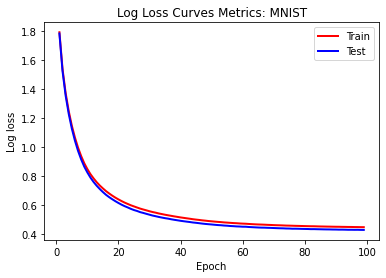

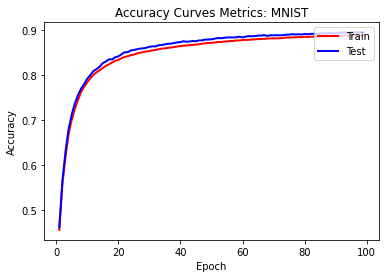

In [ ]:
# Running the 2 hidden layer model with regularization
lr_opt=0.01
epoch_opt=100
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = 'momentum', l2=0.01, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# #TASK 4(UNNORMALIZED IMAGES)

In [ ]:
#Loading and processing data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2])
train_labels = one_hot(train_labels, C = 10, gpu_flag=True)
test_labels = one_hot(test_labels, C = 10, gpu_flag=True)

if xp==cp:
  train_images=xp.array(train_images)
  test_images=xp.array(test_images)

In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.1,0.01]
epoch_list=[51,101]
l_list = [784, 128, 128, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




Epoch : 10 ========= Accuracy_Train : 0.8785, Accuracy_Test : 0.8721
Epoch : 10 ========= Loss_Train : 3.2016177589333576, Loss_Test : 3.5105897136215245
Epoch : 20 ========= Accuracy_Train : 0.9056333333333333, Accuracy_Test : 0.8955
Epoch : 20 ========= Loss_Train : 2.300590422061207, Loss_Test : 2.731560557140389
Epoch : 30 ========= Accuracy_Train : 0.9204, Accuracy_Test : 0.9065
Epoch : 30 ========= Loss_Train : 1.8311989822298782, Loss_Test : 2.387065843370232
Epoch : 40 ========= Accuracy_Train : 0.9288833333333333, Accuracy_Test : 0.9133
Epoch : 40 ========= Loss_Train : 1.5448909401685897, Loss_Test : 2.169630967511206
Epoch : 50 ========= Accuracy_Train : 0.93635, Accuracy_Test : 0.9188
Epoch : 50 ========= Loss_Train : 1.325214414356685, Loss_Test : 2.0151270550028495
Epoch : 60 ========= Accuracy_Train : 0.9410333333333334, Accuracy_Test : 0.922
Epoch : 60 ========= Loss_Train : 1.1692255956797084, Loss_Test : 1.9308824301981695
Epoch : 70 ========= Accuracy_Train : 0.94583

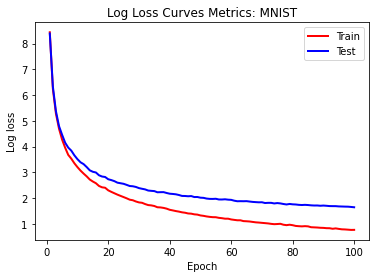

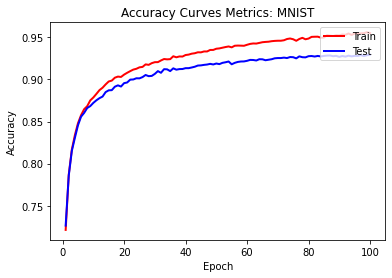

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# # ADDITIONAL EXPERIMENTS 1(DECREASE WIDTH)

In [ ]:
#Re-Loading and Re-processing data to consider normalised data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = preprocess(train_images, gpu_flag=True)
test_images= preprocess(test_images, gpu_flag=True)
train_labels = one_hot(train_labels, C = 10, gpu_flag=True)
test_labels = one_hot(test_labels, C = 10, gpu_flag=True)

In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.1,0.01]
epoch_list=[51,101]
l_list = [784, 64, 64, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




Epoch : 10 ========= Accuracy_Train : 0.35475, Accuracy_Test : 0.3557
Epoch : 10 ========= Loss_Train : 2.020403508661415, Loss_Test : 2.0203260079283574
Epoch : 20 ========= Accuracy_Train : 0.442, Accuracy_Test : 0.4412
Epoch : 20 ========= Loss_Train : 1.852611950139372, Loss_Test : 1.8468471326766291
Epoch : 30 ========= Accuracy_Train : 0.49875, Accuracy_Test : 0.4986
Epoch : 30 ========= Loss_Train : 1.7217384405833, Loss_Test : 1.711985577394768
Epoch : 40 ========= Accuracy_Train : 0.5453166666666667, Accuracy_Test : 0.5483
Epoch : 40 ========= Loss_Train : 1.6138348649256988, Loss_Test : 1.6017342197614335
Epoch : 50 ========= Accuracy_Train : 0.5855833333333333, Accuracy_Test : 0.5904
Epoch : 50 ========= Loss_Train : 1.5176874813112133, Loss_Test : 1.503581192702377
Epoch : 60 ========= Accuracy_Train : 0.6160666666666667, Accuracy_Test : 0.6195
Epoch : 60 ========= Loss_Train : 1.432140391996966, Loss_Test : 1.4156706290801853
Epoch : 70 ========= Accuracy_Train : 0.6431333

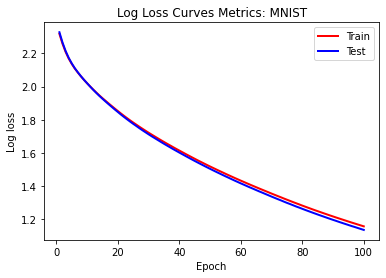

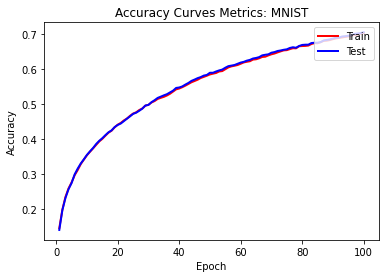

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 64, 64, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# # ADDITIONAL EXPERIMENTS 2 (INCREASE WIDTH)

In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.1,0.01,0.05]
epoch_list=[51,101]
l_list = [784, 256, 256, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)





Epoch : 10 ========= Accuracy_Train : 0.7279166666666667, Accuracy_Test : 0.7338
Epoch : 10 ========= Loss_Train : 1.0090515622960154, Loss_Test : 0.9951852292415416
Epoch : 20 ========= Accuracy_Train : 0.7991666666666667, Accuracy_Test : 0.8062
Epoch : 20 ========= Loss_Train : 0.7286040514631201, Loss_Test : 0.7083973484256789
Epoch : 30 ========= Accuracy_Train : 0.83035, Accuracy_Test : 0.8382
Epoch : 30 ========= Loss_Train : 0.6076434070156855, Loss_Test : 0.5872850603117449
Epoch : 40 ========= Accuracy_Train : 0.84755, Accuracy_Test : 0.8557
Epoch : 40 ========= Loss_Train : 0.5394754915087941, Loss_Test : 0.5198401141962078
Epoch : 50 ========= Accuracy_Train : 0.8599666666666667, Accuracy_Test : 0.8673
Epoch : 50 ========= Loss_Train : 0.49437066211588127, Loss_Test : 0.47572024201944796
Epoch : 60 ========= Accuracy_Train : 0.8686166666666667, Accuracy_Test : 0.8754
Epoch : 60 ========= Loss_Train : 0.46179731543544916, Loss_Test : 0.4437779556868365
Epoch : 70 ========= Ac

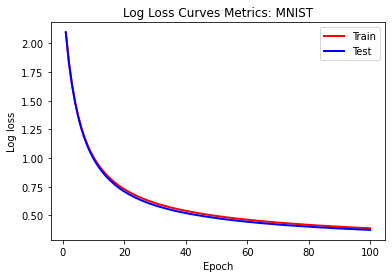

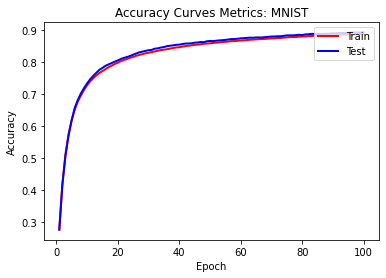

In [ ]:
# Running Stochastic Gradient Descent

acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 256, 256, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=256 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# ADDITIONAL EXPERIMENTS 3 (INCREASE DEPTH)

In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.01,0.001]
epoch_list=[101,501]
l_list = [784, 128, 128, 128, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




Epoch : 10 ========= Accuracy_Train : 0.7580666666666667, Accuracy_Test : 0.7699
Epoch : 10 ========= Loss_Train : 0.908466698728904, Loss_Test : 0.8764917092084547
Epoch : 20 ========= Accuracy_Train : 0.8263833333333334, Accuracy_Test : 0.8339
Epoch : 20 ========= Loss_Train : 0.6236820841238028, Loss_Test : 0.5969886164028748
Epoch : 30 ========= Accuracy_Train : 0.8533166666666666, Accuracy_Test : 0.8576
Epoch : 30 ========= Loss_Train : 0.5188822612732487, Loss_Test : 0.4944323448092392
Epoch : 40 ========= Accuracy_Train : 0.86695, Accuracy_Test : 0.8713
Epoch : 40 ========= Loss_Train : 0.46251180059716185, Loss_Test : 0.4403000240902934
Epoch : 50 ========= Accuracy_Train : 0.8773833333333333, Accuracy_Test : 0.8801
Epoch : 50 ========= Loss_Train : 0.425607738452858, Loss_Test : 0.4044829115325828
Epoch : 60 ========= Accuracy_Train : 0.8834333333333333, Accuracy_Test : 0.8875
Epoch : 60 ========= Loss_Train : 0.4006358224955605, Loss_Test : 0.3801914634159003
Epoch : 70 =====

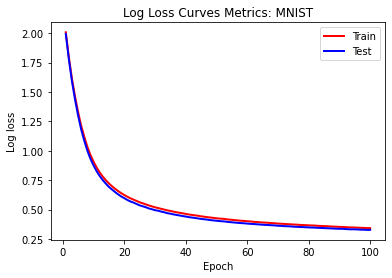

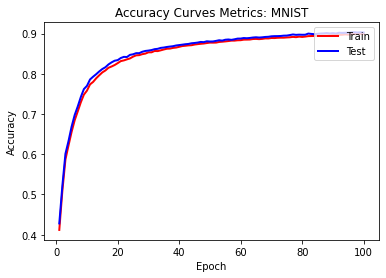

In [ ]:
# Running Stochastic Gradient Descent
epoch_opt=101
lr_opt=0.1
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

Additional Experiments- Comparing the performance of Optimisers: Vanilla SGD, Momentum and Adam.

Epoch : 10 ========= Accuracy_Train : 0.9708333333333333, Accuracy_Test : 0.9636
Epoch : 10 ========= Loss_Train : 0.09924222656805136, Loss_Test : 0.11555437398008453
Epoch : 20 ========= Accuracy_Train : 0.9867666666666667, Accuracy_Test : 0.9742
Epoch : 20 ========= Loss_Train : 0.049176325585893306, Loss_Test : 0.08498633123181253
Epoch : 30 ========= Accuracy_Train : 0.99415, Accuracy_Test : 0.9766
Epoch : 30 ========= Loss_Train : 0.025424186897414408, Loss_Test : 0.0787175271086845
Epoch : 40 ========= Accuracy_Train : 0.9978333333333333, Accuracy_Test : 0.9771
Epoch : 40 ========= Loss_Train : 0.013035049951118632, Loss_Test : 0.07953077736311694
Epoch : 50 ========= Accuracy_Train : 0.9995, Accuracy_Test : 0.9785
Epoch : 50 ========= Loss_Train : 0.0057770956668386445, Loss_Test : 0.08175666227219411


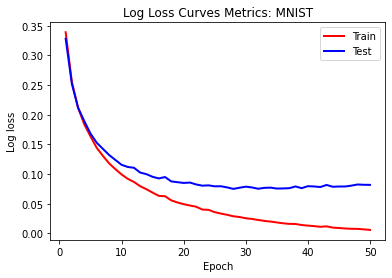

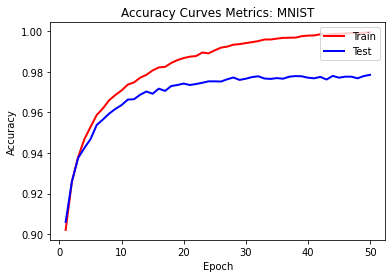

In [ ]:
# Running Stochastic Gradient Descent
lr_opt=0.0001
epoch_opt=51
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')
m='adam'
for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = m, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])

#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])


Comparing the effect of Naive Random initialization and Xavier Initialization on the performance of the algorithm.

In [ ]:
# Running Stochastic Gradient Descent with Random Initialization 
lr_op=0.01
epoch_opt=11
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = m, plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])

#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])


# ADDITIONAL EXPERIMENT 4(DECREASE TRAIN SET)

In [ ]:
 # Running Stochastic Gradient Descent
lr_list=[0.1,0.5]
epoch_list=[51,101]
l_list = [784, 128, 128, 10]
a_fn = 'relu'

epoch_opt, lr_opt , loss_min=hyperparameter_tuning(x=train_images, y=train_labels, l_list = l_list, a_fn = a_fn, lr_list=lr_list, epoch_list2=epoch_list)




j 4
Epoch : 10 ========= Accuracy_Train : 0.6528833333333334, Accuracy_Test : 0.6507
Epoch : 10 ========= Loss_Train : 1.2868129921285982, Loss_Test : 1.2751367932083093
Epoch : 20 ========= Accuracy_Train : 0.7663333333333333, Accuracy_Test : 0.7651
Epoch : 20 ========= Loss_Train : 0.866165968305308, Loss_Test : 0.8491249578815275


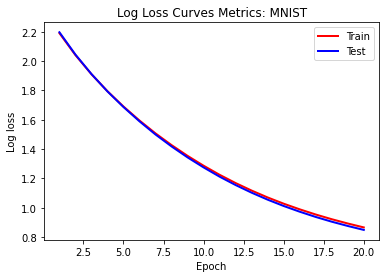

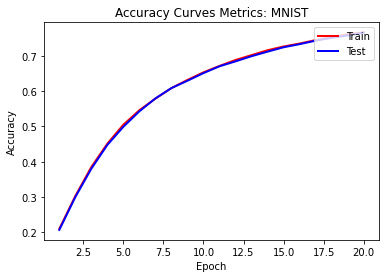

In [ ]:
# Running Stochastic Gradient Descent
epoch_opt=21
lr_opt=0.01
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for j in range(4,5):
     n_rows = xp.power(10, j)
     print("j",j)
     x_train = train_images[:n_rows, :]
     y_train = train_labels[:n_rows, :]
    
     for i in range(1,epoch):

        # Filtering test data to reduce computation
        x_test = test_images
        y_test= test_labels

        # Creating the Model with 2 hidden layers of 128 nodes each
        # We can add layers as needed


        # Fitting the Model
        bs=128 # Setting batch size
        mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
        optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, plot=False)
        model_trained = model.fit(x_train, train_labels, optimizer)

        # Predicting training and test samples
        yh_train = model_trained.predict(train_images)
        yh_test = model_trained.predict(x_test)

        # Calculating accuracy and log loss metrics
        acc_train = eval_acc(train_labels, yh_train)
        acc_test = eval_acc(y_test, yh_test)
        ll_train=log_loss(train_labels, yh_train)
        ll_test= log_loss(y_test,yh_test)

        # Storing metrics in list for plotting
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        ll_train_list.append(ll_train)
        ll_test_list.append(ll_test)
        epoch_list.append(i)
        if (i%10 == 0):
            print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
            print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

     double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
     #Accuracy curves
     double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])

# Additional Experiments ( Data Augmentation)

In [ ]:
from scipy import ndimage

def geometric_transforms(raw_img, plt_img=False):
  lx, ly = raw_img.shape
  # Cropping
  #crop_img = raw_img[lx//4:-lx//4, ly//4:-ly//4].reshape(28,28)
  # up <-> down flip
  flip_img = np.flipud(raw_img)
  # rotation
  rotate_img = ndimage.rotate(raw_img, 45)
  rotate_img_noreshape = ndimage.rotate(raw_img, 45, reshape=False)
  if plt_img:
    plt.figure(figsize=(12.5, 2.5))
    plt.subplot(151)
    plt.imshow(raw_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(152)
    plt.imshow(crop_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(153)
    plt.imshow(flip_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(154)
    plt.imshow(rotate_img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(155)
    plt.imshow(rotate_img_noreshape, cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0,
                      right=1)
    plt.show()
     
  return flip_img, rotate_img_noreshape


def data_augment(x,y,p=0.1):
  N=x.shape[0]
  x_mod, y_mod=[],[]
  for i in range(int(N*p)):
    flip_img, rotate_img_noreshape=geometric_transforms(x[i])
    x_mod.append(flip_img) 
    y_mod.append(train_labels[i])
    x_mod.append(rotate_img_noreshape)
    y_mod.append(train_labels[i])
  x_mod=np.array(x_mod)
  y_mod=np.array(y_mod)
  #print(x_mod.shape,y_mod.shape, y.shape)
  xaug=np.vstack((x,x_mod))
  yaug=np.concatenate((y,y_mod))
  #print(xaug.shape, yaug.shape)
  
  return xaug, yaug


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images_mod, train_labels_mod=data_augment(train_images, train_labels, p=0.2)

train_images = preprocess(train_images_mod, gpu_flag=True)
test_images= preprocess(test_images, gpu_flag=True)
train_labels = one_hot(train_labels_mod, C = 10, gpu_flag=True)
test_labels = one_hot(test_labels, C = 10, gpu_flag=True)


Epoch : 10 ========= Accuracy_Train : 0.7945595238095238, Accuracy_Test : 0.8613
Epoch : 10 ========= Loss_Train : 0.6598006992545384, Loss_Test : 0.47397991019008506
Epoch : 20 ========= Accuracy_Train : 0.8325238095238096, Accuracy_Test : 0.8859
Epoch : 20 ========= Loss_Train : 0.5592692470025539, Loss_Test : 0.40371695352293874
Epoch : 30 ========= Accuracy_Train : 0.8531547619047619, Accuracy_Test : 0.8993
Epoch : 30 ========= Loss_Train : 0.4928702340759347, Loss_Test : 0.359747650818893
Epoch : 40 ========= Accuracy_Train : 0.8713571428571428, Accuracy_Test : 0.9106
Epoch : 40 ========= Loss_Train : 0.43927048398776103, Loss_Test : 0.32530742967474924
Epoch : 50 ========= Accuracy_Train : 0.8839285714285714, Accuracy_Test : 0.9186
Epoch : 50 ========= Loss_Train : 0.3950787408518729, Loss_Test : 0.29113591104806885
Epoch : 60 ========= Accuracy_Train : 0.8970119047619047, Accuracy_Test : 0.9255
Epoch : 60 ========= Loss_Train : 0.3546687201226738, Loss_Test : 0.2637798491817195


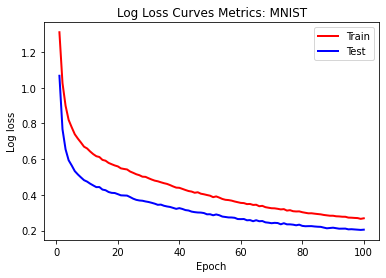

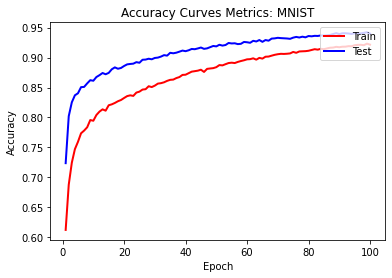

In [ ]:
# Running Stochastic Gradient Descent
epoch_opt=101
lr_opt=0.1
acc_train_list, acc_test_list =[], []
ll_train_list, ll_test_list =[], []
epoch_list=[]
epoch=epoch_opt
model = MLP([784, 128, 128, 10], 'relu')

for i in range(1,epoch):

    # Filtering test data to reduce computation
    x_test = test_images
    y_test= test_labels

    # Creating the Model with 2 hidden layers of 128 nodes each
    # We can add layers as needed

    # Fitting the Model
    bs=128 # Setting batch size
    mi=int(train_images.shape[0]/bs)+1 # Setting maximum steps per epoch
    optimizer = SGD(learning_rate=lr_opt, max_iters=mi, batch_size=bs, method = 'momentum', plot=False)
    model_trained = model.fit(train_images, train_labels, optimizer)

    # Predicting training and test samples
    yh_train = model_trained.predict(train_images)
    yh_test = model_trained.predict(x_test)

    # Calculating accuracy and log loss metrics
    acc_train = eval_acc(train_labels, yh_train)
    acc_test = eval_acc(y_test, yh_test)
    ll_train=log_loss(train_labels, yh_train)
    ll_test= log_loss(y_test,yh_test)

    # Storing metrics in list for plotting
    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)
    ll_train_list.append(ll_train)
    ll_test_list.append(ll_test)
    epoch_list.append(i)
    if (i%10 == 0):
        print(f"Epoch : {i} ========= Accuracy_Train : {acc_train}, Accuracy_Test : {acc_test}")
        print(f"Epoch : {i} ========= Loss_Train : {ll_train}, Loss_Test : {ll_test}")

double_plot(epoch_list, ll_train_list, ll_test_list, "MNIST", "Epoch", "Log loss", "Log Loss Curves", ["Train", "Test"])
#Accuracy curves
double_plot(epoch_list, acc_train_list, acc_test_list, "MNIST", "Epoch", "Accuracy", "Accuracy Curves", ["Train", "Test"])